# Analyze data

* **Input:** `cvr_extract.csv`
* **Contents:** A balanced panel of $ T = 7 $ years (2012-2019) for Danish firms satistfying 
    * Never have net taxable income above 10 mio DKK (or below -10 mio DKK), 
    

In [6]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as sm

In [7]:
import seaborn as sns
sns.set_theme()

In [8]:
yvar = 'tax'

In [9]:
dat = pd.read_csv('REAL_cvr_extract.csv')
dat.sample(3)

,firmid,year,taxable_income,deficit,tax,net_inc,cat,dum_as,dum_aps,dum_ivs,...,dum_dot_dk,dum_doctor,dum_carpenter,dum_transport,dum_plumbing,dum_import,dum_masonry,dum_nielsen,dum_sorensen,dum_cars
466334,58291,2018,2938.0,1133.0,638.0,1805.0,holding,0,1,0,...,0,0,0,0,0,0,0,0,0,0
37714,4714,2014,0.0,0.0,0.0,0.0,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
130610,16326,2014,192318.0,0.0,47114.0,192318.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
cols_dum = [c for c in dat.columns if c[:4] == 'dum_']

In [11]:
for c in cols_dum: 
    dat[c] = dat[c].astype('bool')

In [12]:
N = dat.firmid.unique().size
T = dat.year.unique().size
print(f'Data has {dat.shape[0]:,d} rows: N = {N:,d}, T = {T}')

Data has 519,416 rows: N = 64,927, T = 8


# Quick descriptives

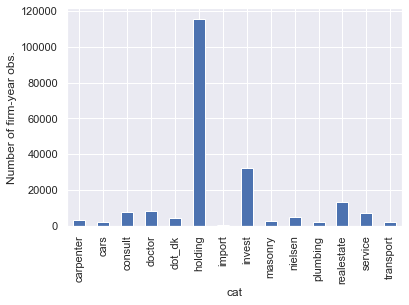

In [13]:
ax = dat.groupby('cat')[yvar].size().plot(kind='bar'); 
ax.set_ylabel('Number of firm-year obs.'); 

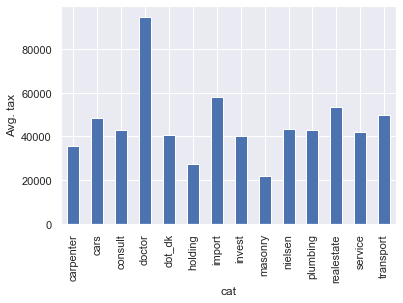

In [14]:
ax = dat.groupby('cat')[yvar].mean().plot(kind='bar'); 
ax.set_ylabel(f'Avg. {yvar}'); 

In [15]:
dat.sort_values(['firmid', 'year'], inplace=True)

# Create lagged net income variable 

In [16]:
lag_yvar = f'lag_{yvar}' # name of the variable 
dat[lag_yvar] = dat.groupby('firmid')[yvar].shift(1) # lag one period (NaN in first year for each firm)

# Pooled OLS estimation

In [17]:
est = []  # fitted regression models 
labs = [] # names of each regression 

In [18]:
est.append(sm.ols(f'{yvar} ~ {lag_yvar}', dat).fit())
labs.append('POLS')
est.append(sm.ols(f'{yvar} ~ {lag_yvar} + C(cat) + C(year)', dat).fit())
labs.append('Cat+year dums')

In [19]:
for c in cols_dum: 
    name = c[4:]
    I = dat[c] == True # find observations for firms with this dummy switched on 
    if I.any(): 
        est.append(sm.ols(f'{yvar} ~ {lag_yvar} ', dat[dat[c] == 1]).fit())
        labs.append(f'{name}')
    else: 
        print(f'Error: no obs. for c={c}')

Error: no obs. for c=dum_sorensen


In [20]:
betas = [(e.params[lag_yvar], 1.96*e.bse[lag_yvar]) for e in est]
res_POLS = pd.DataFrame(betas, columns=['Estimate', 'CI'], index=labs)

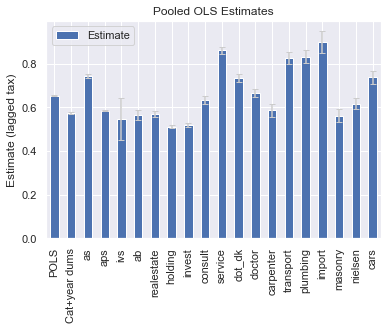

In [21]:
ax = res_POLS.plot(kind='bar', yerr='CI', capsize=3, ecolor=(.8,.8,.8)); 
ax.set_ylabel(f'Estimate (lagged {yvar})'); ax.set_title('Pooled OLS Estimates'); 

# OLS on Demeaned Data

**Warning:** When is this allowed with *dynamics*? ... let's do it anyways to see what we get... 

In [22]:
dat_ = dat.copy()
dat_[f'{yvar}_mean']     = dat_.groupby('firmid')[yvar].transform('mean')
dat_[f'{lag_yvar}_mean'] = dat_.groupby('firmid')[lag_yvar].transform('mean')

dat_[yvar] = dat_[yvar] - dat_[f'{yvar}_mean']
dat_[lag_yvar] = dat_[lag_yvar] - dat_[f'{lag_yvar}_mean']

Run pooled OLS regression on demeaned data 

In [23]:
est = []
labs = [] # names of each regression 

In [24]:
est.append(sm.ols(f'{yvar} ~ {lag_yvar} ', dat_).fit())
labs.append('FE (full)')

In [25]:
for c in cols_dum: 
    name = c[4:]
    I = dat_[c] == True 
    if I.any(): 
        est.append(sm.ols(f'{yvar} ~ {lag_yvar} ', dat_[I]).fit())
        labs.append(f'{name}')
    else: 
        print(f'Error: no obs. for c = {c}')

Error: no obs. for c = dum_sorensen


In [26]:
betas = [(e.params[lag_yvar], 1.96*e.bse[lag_yvar]) for e in est]
res_FE = pd.DataFrame(betas, columns=['Estimate', 'CI'], index=labs)

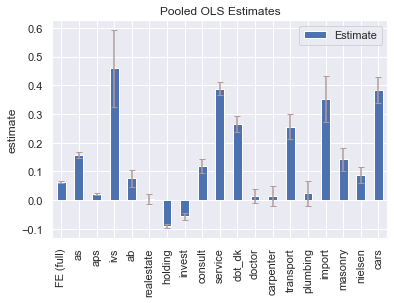

In [27]:
ax = res_FE.plot(kind='bar', yerr='CI', capsize=3, ecolor=(.7,.6,.6)); 
ax.set_ylabel('estimate'); ax.set_title('Pooled OLS Estimates'); 